# Reverse-engineering Strava's Grade Adjusted Pace

## What is Grade Adjusted Pace?

Grade Adjusted Pace (GAP) is a proprietary data product from Strava. Here is a high-level summary from [Strava support](https://support.strava.com/hc/en-us/articles/216917067-Grade-Adjusted-Pace-GAP-):

> Grade Adjusted Pace takes into account the steepness of terrain during your runs and estimates an equivalent pace on flat land. Because running uphill requires extra work, your Grade Adjusted Pace on ascents will be faster than your actual pace. Similarly, when running downhill, your Grade Adjusted Pace will tend to be slower than your actual pace.

In a [2017 post on Strava's engineering blog](https://medium.com/strava-engineering/an-improved-gap-model-8b07ae8886c3), Drew Robb explains that Strava had updated its GAP model. In the old version, based on a [2002 study by Alberto Minetti et al](https://pubmed.ncbi.nlm.nih.gov/12183501/), the runner's rate of energy consumption was used as a proxy for effort. The new model was arrived at using Big Data™, pooling the data from millions of Strava users, and expressing effort in terms of heart rate. 

Setting aside the why and how, let's look at the *what*: the grade adjustment factor itself. 

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*_TwofsNS872wbUS12ykKPQ.png)

Compared to the old energy-consumption-based adjustment factor (blue), the new heart-rate-based adjustment factor (solid orange) gives **much** more credit to downhill running in general. The pace reduction does not dip as low, and it rebounds at a shallower grade; at just 18% downhill, Strava's latest GAP factor claims that the adjusted pace should be *faster* than actual pace. On the other side of the coin, for uphill grades (the right half of the chart) the new adjustment factor assigns a *lower* effort than the old one.

While exploring my personal activity data lake, I found that Strava seemed to be applying the grade adjustment factor to *distance*, not to *pace*. That made me wonder if their conceptual model of "running difficulty" was similar to the "cost of running" model used in Minetti (2002). In that paper, the "cost" of running was given in terms of energy consumed by the human body, per unit distance, per unit mass. In other words, the units of this quantity are calories per kilogram per kilometer. When choosing a model to assume for my reverse-engineered product, I figured the simpler the better. The embedded assumptions in this model are: 
  - The cost of running depends on grade, but is independent of speed.
  - Every person's cost of running curve looks exactly the same. For a given slope, every person spends the same amount of energy (per unit body mass) to cover a mile.

If either of these assumptions sounds absurd, remember: the cost of running is in terms of body mass and distance covered. In order to model how much energy a person consumes getting from A to B, the cost of running gets multiplied by the individual's body mass. And in order to determine the individual's rate of energy consumption, the quantity is divided by time; to cover A to B in a very short time, a very high burn rate is required.

Here is the equation:

$$C_r(g) = 155.4g^5 - 30.4g^4 -43.3g^3 + 46.3g^2 + 19.5g + 3.6$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from specialsauce.sources.minetti import cost_of_running

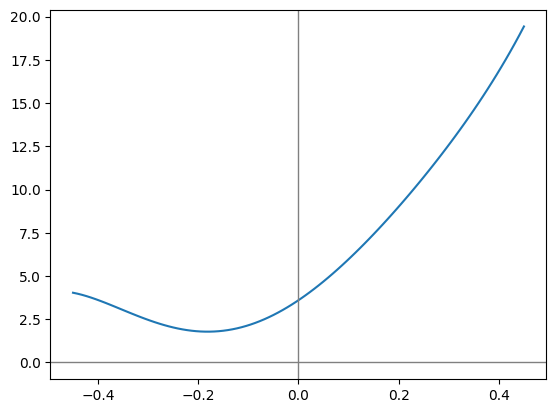

In [2]:
gradient_array = np.linspace(-0.45, 0.45, 100)
plt.plot(gradient_array, cost_of_running(gradient_array))
plt.axhline(0.0, color='gray', linewidth=1)
plt.axvline(0.0, color='gray', linewidth=1)
plt.show()

I have a hunch that Strava's *old* Grade Adjusted Pace product was based on using the Minetti equation to compute a ratio of the cost of running on a slope to the cost of running on flat ground:

$$
  f(g) = c_r(g) / c_r(0)
$$

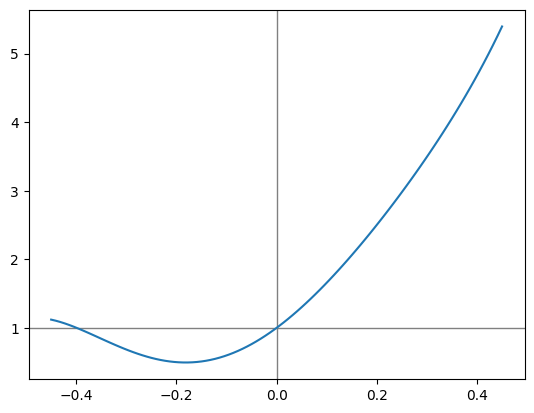

In [3]:
adjustment_factor_array = cost_of_running(gradient_array) / cost_of_running(0.0)

plt.axhline(1.0, color='gray', linewidth=1)
plt.axvline(0.0, color='gray', linewidth=1)
plt.plot(gradient_array, adjustment_factor_array)
plt.show()

...and I think it would be intuitive to calculate adjusted point-to-point distance like:
$$
  \Delta x_g = f(g) \Delta x
$$

In words, that means that the adjusted distance from A to B is a function of the grade at point A.

I want to fit a similar curve to Strava's "grade adjustment factor" (my term). So how can I make it happen, using the data I have at my fingertips?

## The data
*...cracks knuckles...*

In [4]:
import os

import pandas as pd

In [5]:
from dotenv import load_dotenv

load_dotenv()

True

### Time series from the Strava API

I have access to all the time series data for my Strava activities, going back to 2019. In this private dataset, there are over 2.5 million samples, each representing an observation recorded on my activity tracker (a GPS watch). Each observation corresponds to a discrete point in time, and contains a number of variables:

In [6]:
def load_timeseries_data():
    csv_file_path = os.getenv('CSV_FILE_PATH')
    return pd.read_csv(csv_file_path,
                       parse_dates=['timestamp'],
                       index_col=['id', 'timestamp'])

In [7]:
panel_ts_df = load_timeseries_data()
panel_ts_df.columns

Index(['lat', 'lon', 'distance', 'altitude', 'velocity_smooth', 'grade_smooth',
       'cadence', 'heartrate', 'temp', 'watts', 'moving', 'type'],
      dtype='object')

The variable names largely speak for themselves. 

Only two of these variables will be used in my analysis. The first, `distance`, represents cumulative distance traveled from the start of the activity. A bit of rearranging gives me what I am really after: the point-to-point distances between each sample:

In [8]:
delta_x = panel_ts_df['distance'].groupby('id').diff(1).shift(-1)
delta_x.describe()

count    2.581882e+06
mean     5.146323e+00
std      6.688147e+00
min      0.000000e+00
25%      1.300000e+00
50%      3.000000e+00
75%      3.900000e+00
max      3.067000e+02
Name: distance, dtype: float64

Next, I need to grab a time series that Strava calculates on its backend: `grade_smooth`. As the name suggests, this represents grade (terrain slope along the path: $\Delta y / \Delta x$). The time series has also been smoothed in some way. Since grade represents the change in elevation per change in distance, it is sensitive to noisy data.

The grade-smoothing operation is an element of Strava's special sauce. Until I understand this algorithm (among other secrets), I will be forced to continue uploading my activity data to Strava if I want to see the calculated grade time series. That is irrelevant to this post, but it reflects my long-term ambitions: personal data liberation.

Let's get back into the data.

In [9]:
grade = panel_ts_df['grade_smooth']
grade.describe()

count    2.583119e+06
mean     1.325603e+00
std      1.480232e+01
min     -5.000000e+01
25%     -3.800000e+00
50%      3.000000e-01
75%      7.300000e+00
max      5.000000e+01
Name: grade_smooth, dtype: float64

Note the maximum and minimum values: Strava's algorithm will *never* report a grade steeper than 50%. That's a steepness of 5 meters vertical per 10 meters horizontal. Most terrain does not get that steep, unless you go to the mountains. It looks like I am getting sidetracked again.

### Grade Adjusted Distance values from a bulk data download

You know how you can ask for a bulk downloada of all the data you've uploaded to apps and services? Strava is no different. And there's a lot of good stuff in there. What I need is the Grade Adjusted Distance for each activity. Dividing Grade Adjusted Distance by Moving Time yields Grade Adjusted Pace, which is a feature Strava pulled behind their subscription paywall in 2020. Even non-subscribers will see Grade Adjusted Distance in their bulk data download, which really seems like an oversight, but I'll keep quiet since it facilitates this analysis.

In [10]:
from zipfile import ZipFile

def load_activity_summary_data():
    zip_file_path = os.getenv('ZIP_FILE_PATH')
    with ZipFile(zip_file_path, 'r') as zip:
        with zip.open('activities.csv', 'r') as f:
            activities = pd.read_csv(f)
    return activities

In [11]:
activities_df = load_activity_summary_data()
grade_adjusted_distance = activities_df.set_index('Activity ID')['Grade Adjusted Distance']
grade_adjusted_distance.describe()

count     1163.000000
mean     12897.031030
std       7409.794250
min          0.900000
25%       7235.500000
50%      12162.000000
75%      16649.400391
max      73662.101562
Name: Grade Adjusted Distance, dtype: float64

Meters are the distance units here. So in terms of Grade Adjusted Distance, my longest activity is 73.6 kilometers (and I won't soon forget it). And my average is somewhere between 12 and 13 kilometers. That's apparently my sweet spot!

## The method

### Linear regression using `sklearn`

I could go about this a few different ways. I'm choosing to use `sklearn` because it facilitates a generalizable approach - one not limited to polynomial regressions. 

Now I'm going to switch hats and start using the domain language of data science. For each activity in my personal *data lake*, I'll *engineer* a number of *features* I'll take the time series containing samples of all the variables measured during the activity as well as those calculated by Strava (the activity's *multivariate time series*); then I will do some math on them to produce some scalar values - the features. I am *extracting* features from the multivariate timeseries. In keeping with the approach of [[Minetti (2002)]], the features will be of the form

$$
  ftr_m = \sum\limits_{i=0}^{N_{obs}-1} g_i^m \Delta x(i)
$$

Why? Maybe let's take a step back. 

The total distance of an activity is simply the sum of its point-to-point distance time series. 

$$
  x_g = \sum\limits_0^{N_{obs}-1} \Delta x(i)
$$ 

Similarly, the Grade Adjusted Distance of an activity is the sum of its adjusted point-to-point distance.

$$
  x_g = \sum\limits_0^{N_{obs}-1} f(g(i)) \Delta x(i)
$$ 

Since I decided to model the adjustment factor as a polynomial function of grade, this expression becomes

$$
  x_g = \sum\limits_{i=0}^{N_{obs}-1} \sum\limits_{j=0}^5 c_j \cdot g^j(i) \cdot \Delta x(i)
$$

Remember, all I'm looking to determine in this analysis are the coefficients $c_{0..5}$. Everything else is in the data I have available: each activity's Grade Adjusted Distance ($x_g$) as well as all the observations in its time series. To make the data linear-regression-ready, I can engineer features of the form:

$$
  ftr_m = \sum\limits_{i=0}^{N_{obs}-1} g^m(i) \Delta x(i)
$$

...so that for each activity:

$$
  x_g = \sum\limits_{j=0}^5 c_j ftr_j
$$

...and when all activities are considered, a linear regression problem appears:

$$
  \mathbf{x_g} = \mathbf{F} \mathbf{c}
$$

...where $\mathbf{F}$ is the matrix of features that I extract from the activity time series: one row per activity, one column per feature.

There is an unwritten rule that basically says: you have to use *these specific variables* in data science:

$$\mathbf{y} = \mathbf{X} \mathbf{b}$$

So to summarize this confusing twist:
- $\mathbf{x_g} \rightarrow \mathbf{y}$ (the targets)
- $\mathbf{F} \rightarrow \mathbf{X}$ (the features)
- $\mathbf{c} \rightarrow \mathbf{b}$ (the coefficients)

Please don't blame me, I am just speaking the vernacular of data science, trying to fit in.

In [12]:
poly_degree = 5

X_raw = pd.concat(
  [(delta_x * grade ** i).groupby('id').sum() for i in range(poly_degree + 1)],
  axis=1
)

In [13]:
y_raw = grade_adjusted_distance.dropna()

In [14]:
shared_indices = y_raw.index.intersection(X_raw.index)
X = X_raw.loc[shared_indices, :]
y = y_raw[shared_indices]

Now to perform the linear regression itself, where I finally get to figure out the coefficients that give me the best fit.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [16]:
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
rmse = mean_squared_error(y, predictions, squared=False)
rmse

35.85465857601326

For context, the mean and median is on the order of 12000.

The fit's $R^2$ value is close to 1.0. Let's take a look at a scatterplot of my model's predicted Grade Adjusted Distance values vs. "observations" from my Strava bulk download:

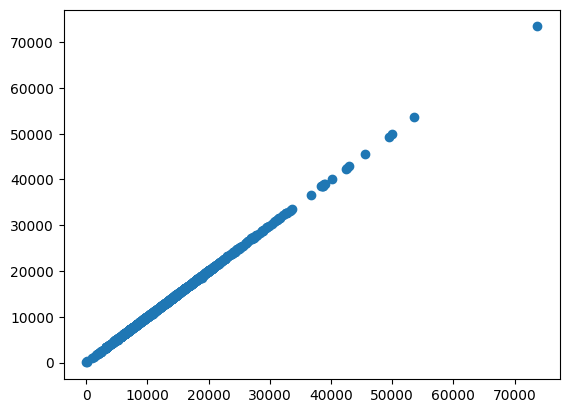

In [17]:
plt.scatter(y, predictions)
plt.show()

It looks like a straight line, right on the diagonal. Now, that isn't a rigorous vetting of the model, but it is quite encouraging. To me, it validates the underlying assumptions - I'm not missing some major detail of Strava's secret implementation. 

## Comparing the result to ground truth

In Strava's blog post [An Improved GAP Model](https://medium.com/strava-engineering/an-improved-gap-model-8b07ae8886c3), there is a graph comparing their "improved" grade adjustment factor to their old one based on [[Minetti (2002)]]. I'll create my own version of this graph, using the two adjustment factor models from my analysis.

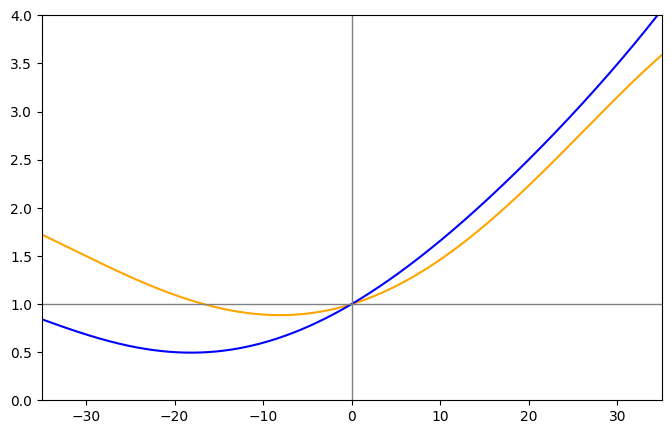

In [21]:
gradient_array = np.linspace(-35, 35, 1000)
poly = np.polynomial.Polynomial(model.coef_)
factor_model = poly(gradient_array)
factor_minetti = cost_of_running(gradient_array/100.0) / cost_of_running(0.0)

plt.figure(figsize=(8, 5))
plt.plot(gradient_array, factor_model, color='orange')
plt.plot(gradient_array, factor_minetti, color='blue')
plt.axhline(1.0, color='gray', linewidth=1)
plt.axvline(0.0, color='gray', linewidth=1)
plt.xlim(-35, 35)
plt.ylim(0, 4)
plt.show()

Look familiar??

![adjustment factor comparison plot from Strava blog](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*_TwofsNS872wbUS12ykKPQ.png)

Now to compare my model of Strava's adjustment factor to **exact** values of the adjustment factor I obtained *elsewhere* (in a story for another time).

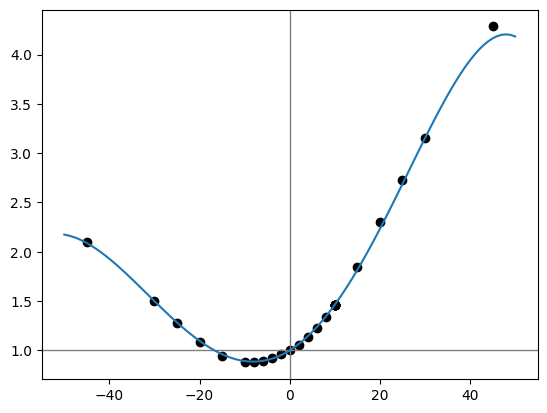

In [19]:
from specialsauce.datasets import load_ngp_gap

df_adjusted_pace = load_ngp_gap()
factor_experiment = df_adjusted_pace['Pace'] / df_adjusted_pace['GAP']

gradient_array = np.linspace(-50, 50, 100)
factor_model = poly(gradient_array)

plt.axhline(1.0, color='gray', linewidth=1)
plt.axvline(0.0, color='gray', linewidth=1)
plt.plot(gradient_array, poly(gradient_array))
plt.scatter(factor_experiment.index, factor_experiment, c='black')
plt.show()

I'll take it. The model's most severe deviation from reality occurs at a grade of 45% - the type of extreme slope that tends to be underrepresented in any runner's fitness history. It makes sense that the model would underperform in a region of training data scarcity.

## Conclusion

With such a large number of data points (thanks to 2.5 million discrete samples in my time series history), it was tempting to throw computing power at the problem of reverse-engineering the GAP algorithm. I hope that this post highlights the potential for compute cost savings when a thoughtful modelling approach is adopted.